# Evaluering av transkripsjoner fra evalueringsløpya

In [1]:
import os
from collections import ChainMap
from functools import lru_cache
from pathlib import Path
from difflib import HtmlDiff


import lxml.etree
import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
from ipywidgets import interact
from IPython.display import display, Markdown, HTML

from samisk_ocr.clean_text_data import clean
import samisk_ocr.trocr
from samisk_ocr.metrics import compute_cer, compute_wer, SpecialCharacterF1

## Last data

In [2]:
load_dotenv("../.env")
config = samisk_ocr.trocr.config.Config()
metadata = pd.read_csv(config.DATA_PATH / "metadata.csv")

test_metadata = metadata.query("file_name.str.startswith('test')")

del metadata

## Hent transkripsjonen fra ALTO filene og sammenstill med datasettet

In [3]:
LANGUAGES = {
    "sma": "Sørsamisk",
    "sme": "Nordsamisk",
    "smj": "Lulesamisk",
    "smn": "Inaresamisk",
}

def urn_col_to_alto_dirname(urncol: str) -> str:
    out = urncol.removeprefix("URN_NBN_no-nb_") 
    if "monografi" in out:
        return out + "_ocr"
    return out + "_ocr_xml"


def urn_col_to_alto_dir(urncol: str) -> Path:
    return Path(os.getenv("NB_ALTO_PATH")) / urn_col_to_alto_dirname(urncol)


def get_alto_file(df: pd.DataFrame) -> str:
    alto_dirname = df["urn"].map(urn_col_to_alto_dirname).str.removesuffix("_xml").str.removesuffix("_ocr")
    ending = df["page"].map(lambda x: f"_{x:04.0f}.xml")
    return df["alto_dir"] / (alto_dirname + ending)


@lru_cache(1000)
def get_alto_textlines(alto_file: Path) -> list[str]:
    # Parse the XML file
    tree = lxml.etree.parse(alto_file)
    
    # Find all TextLine elements
    text_lines = tree.xpath('//TextLine')
    
    # Initialize an empty list to store the concatenated strings
    concatenated_strings = []
    
    # Iterate over each TextLine element
    for text_line in text_lines:
        # Find all String elements within the current TextLine
        strings = text_line.xpath('.//String')
        # Extract the CONTENT attribute from each String element and join them with spaces
        concatenated_content = ' '.join(string.get('CONTENT') for string in strings)
        
        # Check if the last element is an HYP tag
        last_element = text_line.xpath('.//String|.//HYP')[-1]
        if last_element.tag == 'HYP':
            concatenated_content += last_element.get('CONTENT', '')
        
        # Append the concatenated content to the list
        concatenated_strings.append(concatenated_content)
    
    # Print the result
    return concatenated_strings

def get_alto_transcription(alto_file, text):
    if not alto_file.exists():
        return pd.NA
    text_lines = get_alto_textlines(alto_file)
    cleaned_text_lines = [clean(l) for l in text_lines]
    
    return min(cleaned_text_lines, key=lambda l: compute_cer(text, l))

def compute_alto_cer(row):
    return compute_cer(row["text"], row["alto_text_line"])

def compute_alto_wer(row):
    return compute_wer(row["text"], row["alto_text_line"])

In [4]:
test_metadata = test_metadata.assign(
    alto_dir = test_metadata["urn"].map(urn_col_to_alto_dir)
).assign(
    alto_file=get_alto_file
).assign(
    alto_text_line=lambda df: df.apply(lambda row: get_alto_transcription(row['alto_file'], row['text']), axis="columns")
).assign(
    cer=lambda df: df.apply(compute_alto_cer, axis="columns"),
    wer=lambda df: df.apply(compute_alto_wer, axis="columns")
).assign(
    pliktmonografi=lambda df: df["file_name"].str.contains("pliktmonografi")
).assign(
    language=lambda df: df["langcodes"].map(lambda s: LANGUAGES[s.removeprefix("['").removesuffix("']")])
)

## Dobbeltsjekk at vi har funnet transkripsjonen for alle tekstlinjene

In [5]:
pd.testing.assert_frame_equal(test_metadata, test_metadata.dropna())

## Se på tabllen for en rask "sanity check"

In [6]:
test_metadata.sample(10, random_state=42)

,file_name,text,urn,langcodes,page,line,width,height,xmin,xmax,...,text_len,page_30,gt_pix,alto_dir,alto_file,alto_text_line,cer,wer,pliktmonografi,language
95704,test/URN_NBN_no-nb_digibok_2013120908045_0013_...,buorissjivnnjedusáv allasis ánodij.,URN_NBN_no-nb_digibok_2013120908045,['smj'],13.0,13,1086,96,1526,2612,...,35,False,False,/hdd/home/mariero/samisk_ocr_review/data/alto/...,/hdd/home/mariero/samisk_ocr_review/data/alto/...,buorissjivnnjedusåv allasis ånodij.,0.057143,0.666667,False,Lulesamisk
95489,test/URN_NBN_no-nb_digibok_2010082603001_0018_...,daidda galgga jáhkkit.,URN_NBN_no-nb_digibok_2010082603001,['sme'],18.0,14,605,132,183,788,...,22,False,False,/hdd/home/mariero/samisk_ocr_review/data/alto/...,/hdd/home/mariero/samisk_ocr_review/data/alto/...,daidda galgga jåhkkit.,0.045455,0.333333,False,Nordsamisk
95812,test/URN_NBN_no-nb_digibok_2015072408046_0020_...,Dihte mij gøøkte gïelh maahta disse aelhkebe j...,URN_NBN_no-nb_digibok_2015072408046,['sma'],20.0,16,1774,126,542,2316,...,67,False,False,/hdd/home/mariero/samisk_ocr_review/data/alto/...,/hdd/home/mariero/samisk_ocr_review/data/alto/...,Dihte mij gøøkte gielh maahta disse aelhkebe j...,0.029851,0.200000,False,Sørsamisk
95735,test/URN_NBN_no-nb_digibok_2014030408001_0024_...,"peeivičuovvân kuárŋui fakšuustâllâđ, kuás ""pov...",URN_NBN_no-nb_digibok_2014030408001,['smn'],24.0,0,1915,127,240,2155,...,74,False,False,/hdd/home/mariero/samisk_ocr_review/data/alto/...,/hdd/home/mariero/samisk_ocr_review/data/alto/...,"peeivičuovvån kuárrjui fakšuustállâ, kuás ""pov...",0.067568,0.428571,False,Inaresamisk
95969,test/URN_NBN_no-nb_digibok_2018062248001_0034_...,"smietâi val tom, maid Wieseh lâi ettâm.",URN_NBN_no-nb_digibok_2018062248001,['smn'],34.0,28,1259,89,326,1585,...,39,False,False,/hdd/home/mariero/samisk_ocr_review/data/alto/...,/hdd/home/mariero/samisk_ocr_review/data/alto/...,"smietâi val tom, maid Wieseh lâi ettâm.",0.000000,0.000000,False,Inaresamisk
96059,test/URN_NBN_no-nb_digibok_2020040107087_0056_...,"jïh politihkeles, mijjen gïelem vaarjelidh jïh...",URN_NBN_no-nb_digibok_2020040107087,['sma'],56.0,80,1253,98,1576,2829,...,54,False,False,/hdd/home/mariero/samisk_ocr_review/data/alto/...,/hdd/home/mariero/samisk_ocr_review/data/alto/...,"jih politihkeles, mijjen gielem vaarjelidh jih...",0.055556,0.428571,False,Sørsamisk
95831,test/URN_NBN_no-nb_digibok_2016031548149_0138_...,"50 kilomeetter jäävri mield, čielgee Ella. Nje...",URN_NBN_no-nb_digibok_2016031548149,['smn'],138.0,5,1757,73,345,2102,...,85,False,False,/hdd/home/mariero/samisk_ocr_review/data/alto/...,/hdd/home/mariero/samisk_ocr_review/data/alto/...,"50 kilomeetter jäävri mield, čielgee Ella. Nje...",0.047059,0.333333,False,Inaresamisk
95838,test/URN_NBN_no-nb_digibok_2016031548149_0138_...,Kiđđâkeesi iälám oppeet Njellimist. Kuásum tiä...,URN_NBN_no-nb_digibok_2016031548149,['smn'],138.0,12,1773,81,334,2107,...,76,False,False,/hdd/home/mariero/samisk_ocr_review/data/alto/...,/hdd/home/mariero/samisk_ocr_review/data/alto/...,Kiđđåkeesi iälám oppeet Njellimist. Kuásum tiä...,0.026316,0.200000,False,Inaresamisk
95935,test/URN_NBN_no-nb_digibok_2018020648028_0099_...,"SÁRDNIDIŠGOĐII ČEHKÁ-GILLII, NU",URN_NBN_no-nb_digibok_2018020648028,['sme'],99.0,70,973,93,254,1227,...,31,False,False,/hdd/home/mariero/samisk_ocr_review/data/alto/...,/hdd/home/mariero/samisk_ocr_review/data/alto/...,"SÁRDNIDIŠGÖĐIi ČEHKÁ-GILLII, NU",0.064516,0.333333,False,Nordsamisk
96137,test/URN_NBN_no-nb_digibok_2021102848062_0044_...,sierralágásj ræjdo gå sij hábbmiji ietjasa rek...,URN_NBN_no-nb_digibok_2021102848062,['smj'],44.0,15,1910,120,1093,3003,...,69,False,False,/hdd/home/mariero/samisk_ocr_review/data/alto/...,/hdd/home/mariero/samisk_ocr_review/data/alto/...,sierralágásj ræjdo gå sij hábbmiji ietjasa rek...,0.000000,0.000000,False,Lulesamisk


## CER-histogram

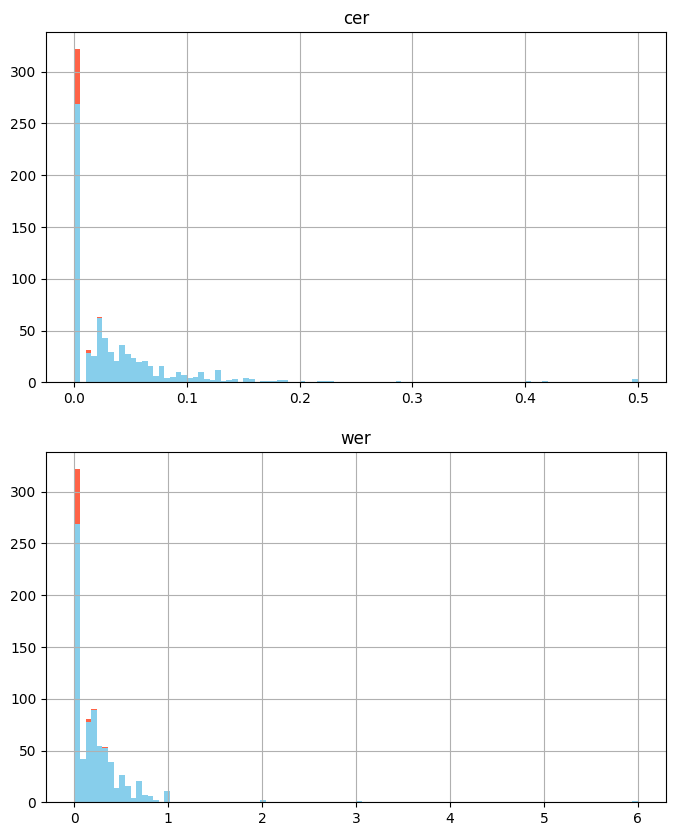

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10))

for ax, metric in zip(axs, ["cer", "wer"]):
    test_metadata[metric].hist(bins=100, ax=ax, color="tomato")
    test_metadata.query("~pliktmonografi")[metric].hist(bins=100, ax=ax, color="skyblue")
    ax.set_title(metric)

## Gjennomsnitt linje-CER

In [8]:
mean_cer = {
    "full": test_metadata["cer"].mean(),
    "pliktmonografi": test_metadata.query("pliktmonografi")["cer"].mean(),
    "digibok": test_metadata.query("~pliktmonografi")["cer"].mean()
}
print(f"Mean cer for alle linjer er {mean_cer["full"]:.2%}, mean cer uten 'pliktmonografi'-linjene er {mean_cer["digibok"]:.2%} og mean cer for kun 'pliktmonografi'-linjene er {mean_cer["pliktmonografi"]:.2%}")

Mean cer for alle linjer er 3.47%, mean cer uten 'pliktmonografi'-linjene er 3.74% og mean cer for kun 'pliktmonografi'-linjene er 0.10%


## Hva er feilene i pliktmonografi-linjene?

In [9]:
with pd.option_context("display.max_colwidth", 1000):
    wrong_columns = (
        test_metadata
        .query("pliktmonografi")
        .query("cer>0")
        [["cer", "wer", "text", "alto_text_line"]]
    )
    display(HTML(
        HtmlDiff().make_file(wrong_columns["text"], wrong_columns["alto_text_line"])       
    ))

Vi ser det bare er whitespace- og bindestreker som er feilene. Det er "uviktige" feil, men feil som vår modell også kan gjøre og derfor blir det ikke urettferdig å ta de med.

## Konkatenering-CER

In [10]:
def compute_concat_cer(df: pd.DataFrame):
    if df.empty:
        return pd.NA

    concat_text = "".join(df["text"])
    concat_alto_text_line = "".join(df["alto_text_line"])
    return compute_cer(concat_text, concat_alto_text_line)
    
concat_cer = {
    "full": compute_concat_cer(test_metadata),
    "pliktmonografi": compute_concat_cer(test_metadata.query("pliktmonografi")),
    "digibok": compute_concat_cer(test_metadata.query("~pliktmonografi")),
}
print(f"Concat cer for alle linjer er {concat_cer["full"]:.2%}, concat cer uten 'pliktmonografi'-linjene er {concat_cer["digibok"]:.2%} og concat cer for kun 'pliktmonografi'-linjene er {concat_cer["pliktmonografi"]:.2%}")

Concat cer for alle linjer er 3.15%, concat cer uten 'pliktmonografi'-linjene er 3.50% og concat cer for kun 'pliktmonografi'-linjene er 0.10%


# Gjennomsnitt linje-WER

In [11]:
mean_wer = {
    "full": test_metadata["wer"].mean(),
    "pliktmonografi": test_metadata.query("pliktmonografi")["wer"].mean(),
    "digibok": test_metadata.query("~pliktmonografi")["wer"].mean()
}
print(f"Mean wer for alle linjer er {mean_wer["full"]:.2%}, mean wer uten 'pliktmonografi'-linjene er {mean_wer["digibok"]:.2%} og mean wer for kun 'pliktmonografi'-linjene er {mean_wer["pliktmonografi"]:.2%}")

Mean wer for alle linjer er 20.46%, mean wer uten 'pliktmonografi'-linjene er 21.94% og mean wer for kun 'pliktmonografi'-linjene er 1.46%


# Konkatenering-WER

In [12]:
def compute_concat_wer(df: pd.DataFrame):
    if df.empty:
        return pd.NA

    concat_text = " ".join(df["text"])
    concat_alto_text_line = " ".join(df["alto_text_line"])
    return compute_wer(concat_text, concat_alto_text_line)
    
concat_wer = {
    "full": compute_concat_wer(test_metadata),
    "pliktmonografi": compute_concat_wer(test_metadata.query("pliktmonografi")),
    "digibok": compute_concat_wer(test_metadata.query("~pliktmonografi")),
}
print(f"Concat wer for alle linjer er {concat_wer["full"]:.2%}, concat wer uten 'pliktmonografi'-linjene er {concat_wer["digibok"]:.2%} og concat wer for kun 'pliktmonografi'-linjene er {concat_wer["pliktmonografi"]:.2%}")

Concat wer for alle linjer er 18.11%, concat wer uten 'pliktmonografi'-linjene er 19.92% og concat wer for kun 'pliktmonografi'-linjene er 1.46%


## Total CER og WER

In [13]:
HTML(
    pd.DataFrame({
        ("CER", "Gjennomsnitt"): mean_cer,
        ("CER", "Konkatenering"): concat_cer,
        ("WER", "Gjennomsnitt"): mean_wer,
        ("WER", "Konkatenering"): concat_wer,
    })
    .rename(index={"full": "Totalt"})
    .loc[["pliktmonografi", "digibok", "Totalt"]]
    .to_html(float_format=lambda f: f"{f:.2%}")
)

## Språkspesifikke metrikker

In [14]:
def compute_all(df, func):
    return {
        "full": func(df),
        "pliktmonografi": func(df.query("pliktmonografi")),
        "digibok": func(df.query("~pliktmonografi"))
    }

def compute_all_mean_cer(df):
    return compute_all(df, lambda df: df["cer"].mean() if not df.empty else pd.NA)

def compute_all_concat_cer(df):
    return compute_all(df, compute_concat_cer)

def compute_all_mean_wer(df):
    return compute_all(df, lambda df: df["wer"].mean() if not df.empty else pd.NA)
    
def compute_all_concat_wer(df):
    return compute_all(df, compute_concat_wer)

In [15]:

HTML(
    pd.DataFrame(
        dict(ChainMap(*({
            ("Gjennomsnitt", "CER", lang): compute_all_mean_cer(df),
            ("Konkatenering", "CER", lang): compute_all_concat_cer(df),
            ("Gjennomsnitt", "WER", lang): compute_all_mean_wer(df),
            ("Konkatenering", "WER", lang): compute_all_concat_wer(df)
        } for lang, df in test_metadata.groupby("language")))
    ))
    .rename(index={"full": "Totalt"})
    .T.sort_index()
    .unstack(level=2)
    .to_html(float_format=lambda f: f"{f:.2%}")
)

In [16]:
concat_true = " ".join(test_metadata.dropna(subset="alto_text_line")["text"])
concat_alto = " ".join(test_metadata.dropna(subset="alto_text_line")["alto_text_line"])

compute_cer(concat_true, concat_alto)

0.030902288518536516

## Special character F1 scores

F1 score is given by either:

$$ \frac{TP}{2TP + FP + FN}, $$

or, equivalently

$$ \frac{TP}{\frac{1}{2} (N_{GT} + N_{PRED})} $$

i.e. the number of correctly found special characters divided by the average of the number of special characters in the ground truth and the number of predicted special characters

In [17]:
letters = pd.read_csv("../data/common/samiske_bokstaver_med_sprak.csv")
sami_letters = {
    lang: sorted(set(letters.query(lang)["bokstav"]) - set(letters.query("nor")["bokstav"]))
    for lang in LANGUAGES
}

sami_metrics = {LANGUAGES[k]: SpecialCharacterF1(alphabet) for k, alphabet in sami_letters.items()}

def compute_sami_f1(df, language):
    metric = sami_metrics[language]
    return df.apply(lambda row: metric(row["text"], row["alto_text_line"]), axis=1).mean()

In [18]:
data_frames = {
    "Totalt": test_metadata,
    "pliktmonografi": test_metadata.query("pliktmonografi"),
    "digibok": test_metadata.query("~pliktmonografi"),
}

for name, df in data_frames.items():
    special_character_f1 = pd.DataFrame(
        dict(ChainMap(*({
            corpus_language: pd.Series(
                [compute_sami_f1(df_inner, alphabet_language) for alphabet_language in LANGUAGES.values()],
                index=pd.Index(LANGUAGES.values(), name="Språk for spesialtegn")
            )
        } for corpus_language, df_inner in df.groupby("language"))))
    )
    
    special_character_f1.columns.name = "Korpusspråk"
    special_character_f1["Totalt"] = pd.Series(
        [compute_sami_f1(df, lang) for lang in LANGUAGES.values()],
        index=pd.Index(LANGUAGES.values(), name="Språk for spesialtegn")
    )
    special_character_f1 = special_character_f1.T.reset_index().assign(Korpus=name).set_index(["Korpus", "Korpusspråk"]).T
    display(special_character_f1)

Korpus                   Totalt                                            
Korpusspråk           Sørsamisk Nordsamisk Lulesamisk Inaresamisk    Totalt
Språk for spesialtegn                                                      
Sørsamisk              0.385747   0.000000        NaN    1.000000  0.387302
Nordsamisk                  NaN   0.396907   0.582071    0.744113  0.556213
Lulesamisk                  NaN   0.391566   0.582071    0.736855  0.559083
Inaresamisk                 NaN   0.396907   0.582071    0.685973  0.539825

Korpus                pliktmonografi                  
Korpusspråk                Sørsamisk Lulesamisk Totalt
Språk for spesialtegn                                 
Sørsamisk                        1.0        NaN    1.0
Nordsamisk                       NaN        1.0    1.0
Lulesamisk                       NaN        1.0    1.0
Inaresamisk                      NaN        1.0    1.0

Korpus                  digibok                                            
Korpusspråk           Sørsamisk Nordsamisk Lulesamisk Inaresamisk    Totalt
Språk for spesialtegn                                                      
Sørsamisk              0.245198   0.000000        NaN    1.000000  0.249444
Nordsamisk                  NaN   0.396907   0.517483    0.744113  0.539485
Lulesamisk                  NaN   0.391566   0.517483    0.736855  0.541064
Inaresamisk                 NaN   0.396907   0.517483    0.685973  0.522707